In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scanpy as sc
import scanpy.external as sce
import anndata as ad
import matplotlib as mpl
import matplotlib.pyplot as plt
import loompy as lp
import os
import scipy
from adjustText import adjust_text
sc.settings.verbosity = 3
sc.logging.print_header()
sc.set_figure_params(dpi=600, dpi_save=600)

from pyscenic.export import export2loom, add_scenic_metadata
from pyscenic.utils import load_motifs
from pyscenic.transform import df2regulons
from pyscenic.aucell import aucell
from pyscenic.binarization import binarize
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_binarization, plot_rss

/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) -> int:
/home/yq

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.21.6 scipy==1.11.1 pandas==1.3.5 scikit-learn==1.3.0 statsmodels==0.14.0 pynndescent==0.5.10


In [2]:
# set a working directory
wdir = "/mnt/g/YS_work2/8.Fib_Epi_pyScenic/"
os.chdir(wdir)

# path to loom file with basic filtering applied (this will be created in the "initial filtering" step below).
f_loom_path_scenic = os.path.join(wdir, 'YS_filtered_for_scenic.loom')

In [3]:
# Create these folders manually
auxilliaries_foldername = os.path.join(wdir,"auxilliaries/")
results_foldername = os.path.join(wdir,"YS_fib_epi/results/")
figures_foldername = os.path.join(wdir,"YS_fib_epi/figures/")

In [4]:
# Auxilliary data sets, put the files into corresponding folders
hs_tfs_fname = os.path.join(auxilliaries_foldername, 'hs_hgnc_tfs.txt')
ranking_dbs_fnames = list(map(lambda fn: os.path.join(auxilliaries_foldername, fn),
                       ['hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings.feather', 'hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr.genes_vs_motifs.rankings.feather']))
motif_annotations_fname = os.path.join(auxilliaries_foldername, 'motifs-v9-nr.hgnc-m0.001-o0.0.tbl')


In [6]:
adata=sc.read('/mnt/g/YS_work2/5.Fib_Epi/YS_adata_fib_epi_raw.h5ad')
adata

AnnData object with n_obs × n_vars = 29545 × 36601
    obs: 'predicted_doublets', 'batch'
    var: 'gene_ids'

In [5]:
# Create results path with lowercase names
dataset_id = "YS_fib_epi"
adjacencies_fname = os.path.join(results_foldername, '{}.adjacencies.tsv'.format(dataset_id))
motifs_fname = os.path.join(results_foldername, '{}.motifs.csv'.format(dataset_id))
regulons_dat_fname = os.path.join(results_foldername, '{}.regulons.dat'.format(dataset_id))
aucell_mtx_fname = os.path.join(results_foldername, '{}.aucell.csv'.format(dataset_id))
outloom=os.path.join(wdir,'ys_fib_epi_out_SCENIC.loom')

normalizing counts per cell
    finished (0:00:02)


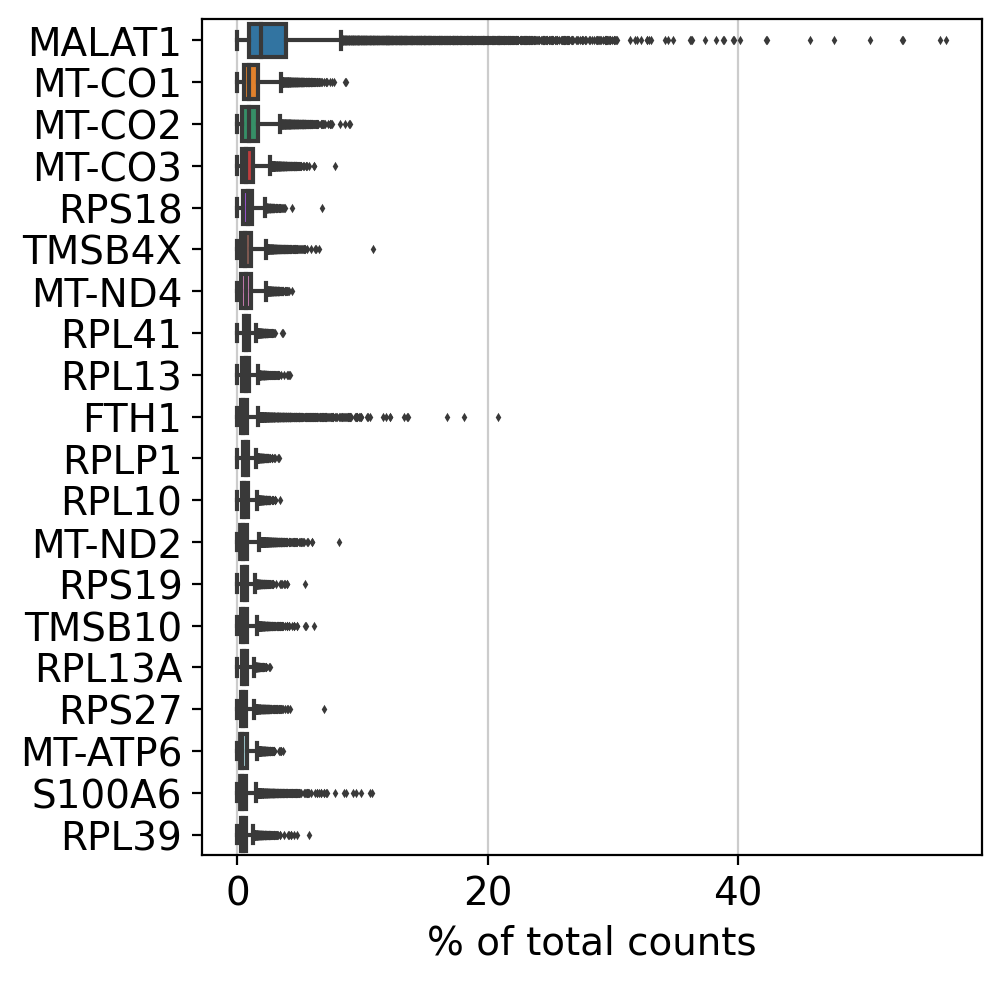

filtered out 11936 genes that are detected in less than 25 cells


AnnData object with n_obs × n_vars = 29545 × 24665
    obs: 'predicted_doublets', 'batch', 'n_genes'
    var: 'gene_ids', 'n_cells'

In [9]:
sc.pl.highest_expr_genes(adata, n_top=20)
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=25)
adata

In [10]:
row_attrs = {"Gene": np.array(adata.var_names)}
col_attrs = {"CellID": np.array(adata.obs_names), "nGene": np.array(np.sum(adata.X.transpose()>0, axis=0)).flatten(),
             "nUMI": np.array(np.sum(adata.X.transpose(), axis=0)).flatten()}
lp.create(f_loom_path_scenic, adata.X.transpose(), row_attrs, col_attrs)

In [11]:
%%time
!pyscenic grn {f_loom_path_scenic} {hs_tfs_fname} -o {adjacencies_fname} --num_workers 32
# num_workers>16 may make memory budget error

/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) -> int:
/home/yq

/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) -> int:
/home/yq

/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) -> int:
/home/yq

/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) -> int:
/home/yq

/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) -> int:
/home/yq

/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) -> int:
/home/yq

2023-08-09 23:07:34,613 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:38311
Traceback (most recent call last):
  File "/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/asyncio/tasks.py", line 490, in wait_for
    return fut.result()
asyncio.exceptions.CancelledError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/distributed/comm/core.py", line 392, in connect
    handshake = await wait_for(comm.read(), time_left())
  File "/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/distributed/utils.

2023-08-09 23:07:41,094 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:38311
Traceback (most recent call last):
  File "/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/asyncio/tasks.py", line 490, in wait_for
    return fut.result()
asyncio.exceptions.CancelledError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/distributed/comm/core.py", line 392, in connect
    handshake = await wait_for(comm.read(), time_left())
  File "/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/distributed/utils.

2023-08-09 23:08:17,556 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:38311
Traceback (most recent call last):
  File "/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/distributed/comm/tcp.py", line 266, in write
    async def write(self, msg, serializers=None, on_error="message"):
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/asyncio/tasks.py", line 452, in wait_for
    return fut.result()
asyncio.exceptions.CancelledError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/distributed/comm/core.py", line 393, in connect
    await wait_for(comm.write(local_info), time_left())
  File "/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/di

2023-08-09 23:09:05,583 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:41461
Traceback (most recent call last):
  File "/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/asyncio/tasks.py", line 490, in wait_for
    return fut.result()
asyncio.exceptions.CancelledError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/distributed/comm/core.py", line 392, in connect
    handshake = await wait_for(comm.read(), time_left())
  File "/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/distributed/utils.

2023-08-09 23:09:24,700 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:36081
Traceback (most recent call last):
  File "/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/asyncio/tasks.py", line 490, in wait_for
    return fut.result()
asyncio.exceptions.CancelledError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/distributed/comm/core.py", line 392, in connect
    handshake = await wait_for(comm.read(), time_left())
  File "/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/distributed/utils.

2023-08-09 23:09:26,616 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:41461
Traceback (most recent call last):
  File "/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/asyncio/tasks.py", line 490, in wait_for
    return fut.result()
asyncio.exceptions.CancelledError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/distributed/comm/core.py", line 392, in connect
    handshake = await wait_for(comm.read(), time_left())
  File "/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/distributed/utils.

2023-08-09 23:09:57,290 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:41461
Traceback (most recent call last):
  File "/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/asyncio/tasks.py", line 490, in wait_for
    return fut.result()
asyncio.exceptions.CancelledError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/distributed/comm/core.py", line 392, in connect
    handshake = await wait_for(comm.read(), time_left())
  File "/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/distributed/utils.

  File "/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/distributed/comm/core.py", line 397, in connect
    raise OSError(
OSError: Timed out during handshake while connecting to tcp://127.0.0.1:44537 after 30 s
2023-08-09 23:10:18,799 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:41461
Traceback (most recent call last):
  File "/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/asyncio/tasks.py", line 490, in wait_for
    return fut.result()
asyncio.exceptions.CancelledError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/yqcj/miniconda3/envs/PyScen

2023-08-09 23:10:22,161 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:36081
Traceback (most recent call last):
  File "/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/asyncio/tasks.py", line 490, in wait_for
    return fut.result()
asyncio.exceptions.CancelledError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/distributed/comm/core.py", line 392, in connect
    handshake = await wait_for(comm.read(), time_left())
  File "/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/distributed/utils.

2023-08-09 23:10:26,499 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:33375
Traceback (most recent call last):
  File "/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/distributed/comm/tcp.py", line 266, in write
    async def write(self, msg, serializers=None, on_error="message"):
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/asyncio/tasks.py", line 452, in wait_for
    return fut.result()
asyncio.exceptions.CancelledError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/distributed/comm/core.py", line 393, in connect
    await wait_for(comm.write(local_info), time_left())
  File "/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/di

2023-08-10 01:25:46,803 - distributed.nanny - WARNING - Worker process still alive after 3.199997253417969 seconds, killing
2023-08-10 01:25:46,824 - distributed.nanny - WARNING - Worker process still alive after 3.1999981689453127 seconds, killing
2023-08-10 01:25:46,825 - distributed.nanny - WARNING - Worker process still alive after 3.1999975585937506 seconds, killing
2023-08-10 01:25:46,825 - distributed.nanny - WARNING - Worker process still alive after 3.1999978637695317 seconds, killing
2023-08-10 01:25:46,826 - distributed.nanny - WARNING - Worker process still alive after 3.1999978637695317 seconds, killing
2023-08-10 01:25:46,827 - distributed.nanny - WARNING - Worker process still alive after 3.19999740600586 seconds, killing
2023-08-10 01:25:46,839 - distributed.nanny - WARNING - Worker process still alive after 3.1999971008300783 seconds, killing
2023-08-10 01:25:46,839 - distributed.nanny - WARNING - Worker process still alive after 3.199997253417969 seconds, killing

202

In [12]:
dbs_param = ' '.join(ranking_dbs_fnames)

In [ ]:
%%time
!pyscenic ctx {adjacencies_fname} {dbs_param} \
            --annotations_fname {motif_annotations_fname} \
            --expression_mtx_fname {f_loom_path_scenic} \
            --output {motifs_fname} \
            --num_workers 32
# The results is a list of enriched motifs for the modules

/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/yqcj/miniconda3/envs/PyScenic38/lib/python3.9/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) -> int:
/home/yq

In [ ]:
%%time
!pyscenic aucell \
    {f_loom_path_scenic} \
    {motifs_fname} \
    --output {outloom} \
    --num_workers 32

In [ ]:
%%time
!pyscenic aucell \
    {f_loom_path_scenic} \
    {motifs_fname} \
    --output {aucell_mtx_fname} \
    --num_workers 32

In [6]:
auc_mtx = pd.read_csv(aucell_mtx_fname, index_col=0)
auc_mtx

ARID5B(+)   ATF4(+)  ATOH1(+)  BHLHE40(+)  \
Cell                                                                   
AAACCTGGTTACTGAC-1-S-1      0.000000  0.067593  0.000000    0.054530   
AAAGCAATCCCATTTA-1-S-1      0.000000  0.072128  0.008817    0.063388   
AACACGTGTGCTTCTC-1-S-1      0.000000  0.055566  0.000000    0.040544   
AACCGCGAGTGTCCCG-1-S-1      0.051327  0.070599  0.017032    0.052979   
AACTCCCTCAGCTCGG-1-S-1      0.000000  0.057674  0.021523    0.033698   
...                              ...       ...       ...         ...   
TTTGCGCCATGGAATA-1-SMC25T   0.000000  0.073426  0.000000    0.067920   
TTTGCGCCATGTTCCC-1-SMC25T   0.000000  0.072577  0.000000    0.069637   
TTTGGTTGTAGGGTAC-1-SMC25T   0.000000  0.071688  0.000000    0.063149   
TTTGTCAAGAGGGATA-1-SMC25T   0.000000  0.082627  0.000000    0.102762   
TTTGTCATCCCAAGTA-1-SMC25T   0.094775  0.045383  0.000000    0.036910   

                            CDX1(+)   CDX2(+)  CEBPB(+)  CEBPG(+)    CIC(+)  \
Cell                                                                          
AAACCTGGTTACTGAC-1-S-1     0.099847  0.024279  0.072478  0.058695  0.000000   
AAAGCAATCCCATTTA-1-S-1     0.077859  0.029459  0.068667  0.062551  0.000000   
AACACGTGTGCTTCTC-1-S-1     0.027282  0.026014  0.062301  0.052671  0.000000   
AACCGCGAGTGTCCCG-1-S-1     0.027755  0.023673  0.072465  0.057697  0.000000   
AACTCCCTCAGCTCGG-1-S-1     0.025052  0.030945  0.079281  0.031860  0.000000   
...                             ...       ...       ...       ...       ...   
TTTGCGCCATGGAATA-1-SMC25T  0.144025  0.045261  0.037976  0.080268  0.000000   
TTTGCGCCATGTTCCC-1-SMC25T  0.185771  0.056172  0.037305  0.087409  0.000000   
TTTGGTTGTAGGGTAC-1-SMC25T  0.187078  0.050605  0.036184  0.079919  0.029805   
TTTGTCAAGAGGGATA-1-SMC25T  0.095003  0.041289  0.054776  0.098820  0.000000   
TTTGTCATCCCAAGTA-1-SMC25T  0.065085  0.029798  0.033873  0.052576  0.000000   

                           CREB3L1(+)  ...  TFDP1(+)   TFF3(+)  TWIST1(+)  \
Cell                                   ...                                  
AAACCTGGTTACTGAC-1-S-1       0.083920  ...  0.021341  0.023987   0.083451   
AAAGCAATCCCATTTA-1-S-1       0.065028  ...  0.021685  0.020901   0.085743   
AACACGTGTGCTTCTC-1-S-1       0.063519  ...  0.019333  0.024980   0.097749   
AACCGCGAGTGTCCCG-1-S-1       0.081639  ...  0.021860  0.016719   0.083979   
AACTCCCTCAGCTCGG-1-S-1       0.071609  ...  0.019512  0.018837   0.114407   
...                               ...  ...       ...       ...        ...   
TTTGCGCCATGGAATA-1-SMC25T    0.027112  ...  0.020744  0.062703   0.004389   
TTTGCGCCATGTTCCC-1-SMC25T    0.018232  ...  0.026452  0.063617   0.002338   
TTTGGTTGTAGGGTAC-1-SMC25T    0.028273  ...  0.036468  0.067489   0.006629   
TTTGTCAAGAGGGATA-1-SMC25T    0.025460  ...  0.018889  0.062094   0.006631   
TTTGTCATCCCAAGTA-1-SMC25T    0.025452  ...  0.021983  0.027870   0.021682   

                           TWIST2(+)   XBP1(+)   ZEB1(+)  ZNF572(+)  \
Cell                                                                  
AAACCTGGTTACTGAC-1-S-1      0.120812  0.025690  0.076440        0.0   
AAAGCAATCCCATTTA-1-S-1      0.126413  0.035314  0.117735        0.0   
AACACGTGTGCTTCTC-1-S-1      0.098375  0.030544  0.068127        0.0   
AACCGCGAGTGTCCCG-1-S-1      0.075495  0.035266  0.119357        0.0   
AACTCCCTCAGCTCGG-1-S-1      0.115255  0.023791  0.234793        0.0   
...                              ...       ...       ...        ...   
TTTGCGCCATGGAATA-1-SMC25T   0.000000  0.045709  0.000000        0.0   
TTTGCGCCATGTTCCC-1-SMC25T   0.000000  0.046197  0.000000        0.0   
TTTGGTTGTAGGGTAC-1-SMC25T   0.000000  0.044059  0.000000        0.0   
TTTGTCAAGAGGGATA-1-SMC25T   0.008782  0.048453  0.000000        0.0   
TTTGTCATCCCAAGTA-1-SMC25T   0.006285  0.026790  0.000000        0.0   

                           ZNF619(+)  ZNF74(+)  ZNF831(+)  
Cell                                                       
AAACCTGGTTACTGAC

In [7]:
from pyscenic.cli.utils import load_signatures
regulons = load_signatures(motifs_fname)

Create regulons from a dataframe of enriched features.
Additional columns saved: []


In [13]:
adata=sc.read('/mnt/g/YS_work2/5.Fib_Epi/YS_adata_fib_epi_after_newcelltype.h5ad')

In [14]:
adata

AnnData object with n_obs × n_vars = 29545 × 5000
    obs: 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp', 'leiden', 'Fib_Epi_Cluster'
    var: 'gene_ids', 'mt', 'rp', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Fib_Epi_Cluster_colors', 'batch_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [15]:
add_scenic_metadata(adata, auc_mtx, regulons)

AnnData object with n_obs × n_vars = 29545 × 5000
    obs: 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp', 'leiden', 'Fib_Epi_Cluster', 'Regulon(ARID5B(+))', 'Regulon(ATF4(+))', 'Regulon(ATOH1(+))', 'Regulon(BHLHE40(+))', 'Regulon(CDX1(+))', 'Regulon(CDX2(+))', 'Regulon(CEBPB(+))', 'Regulon(CEBPG(+))', 'Regulon(CIC(+))', 'Regulon(CREB3L1(+))', 'Regulon(CREM(+))', 'Regulon(CUX1(+))', 'Regulon(E2F8(+))', 'Regulon(EGR1(+))', 'Regulon(ELF1(+))', 'Regulon(ELF3(+))', 'Regulon(EPAS1(+))', 'Regulon(ESRRA(+))', 'Regulon(FLI1(+))', 'Regulon(FOS(+))', 'Regulon(FOSB(+))', 'Regulon(FOSL1(+))', 'Regulon(FOXD1(+))', 'Regulon(FOXF1(+))', 'Regulon(FOXF2(+))', 'Regulon(FOXP1(+))', 'Regulon(GATA3(+))', 'Regulon(GFI1B(+))', 'Regulon(HDAC2(+))', 'Regulon(HMGA1(+))', 'Regulon(HNF4A(+))', 'Regulon(HOXD10(+))', 'Regulon(HOXD13(+))', 'Regulon(HOXD3(+))', 'Regulon(IKZF1(+))', 'Regulon(IRF1(+))', 'Regulon(IRF7(+))', 'Regu

In [16]:
df_obs = adata.obs

In [17]:
signature_column_names = list(df_obs.select_dtypes('number').columns)
signature_column_names = list(filter(lambda s: s.startswith('Regulon('), signature_column_names))
df_scores = df_obs[signature_column_names + ['Fib_Epi_Cluster']]
df_results = ((df_scores.groupby(by='Fib_Epi_Cluster').mean() - df_obs[signature_column_names].mean())/ df_obs[signature_column_names].std()).stack().reset_index().rename(columns={'level_1': 'regulon', 0:'Z'})
df_results['Regulon'] = list(map(lambda s: s[8:-1], df_results.regulon))
df_results[(df_results.Z >= 1)].sort_values(['Fib_Epi_Cluster', 'Z'], ascending=False).to_csv('YS_epi_regulons.csv')

In [18]:
def savesvg(fname: str, fig, folder: str=figures_foldername) -> None:
    """
    Save figure as vector-based SVG image format.
    """
    fig.tight_layout()
    fig.savefig(os.path.join(folder, fname), format='svg')

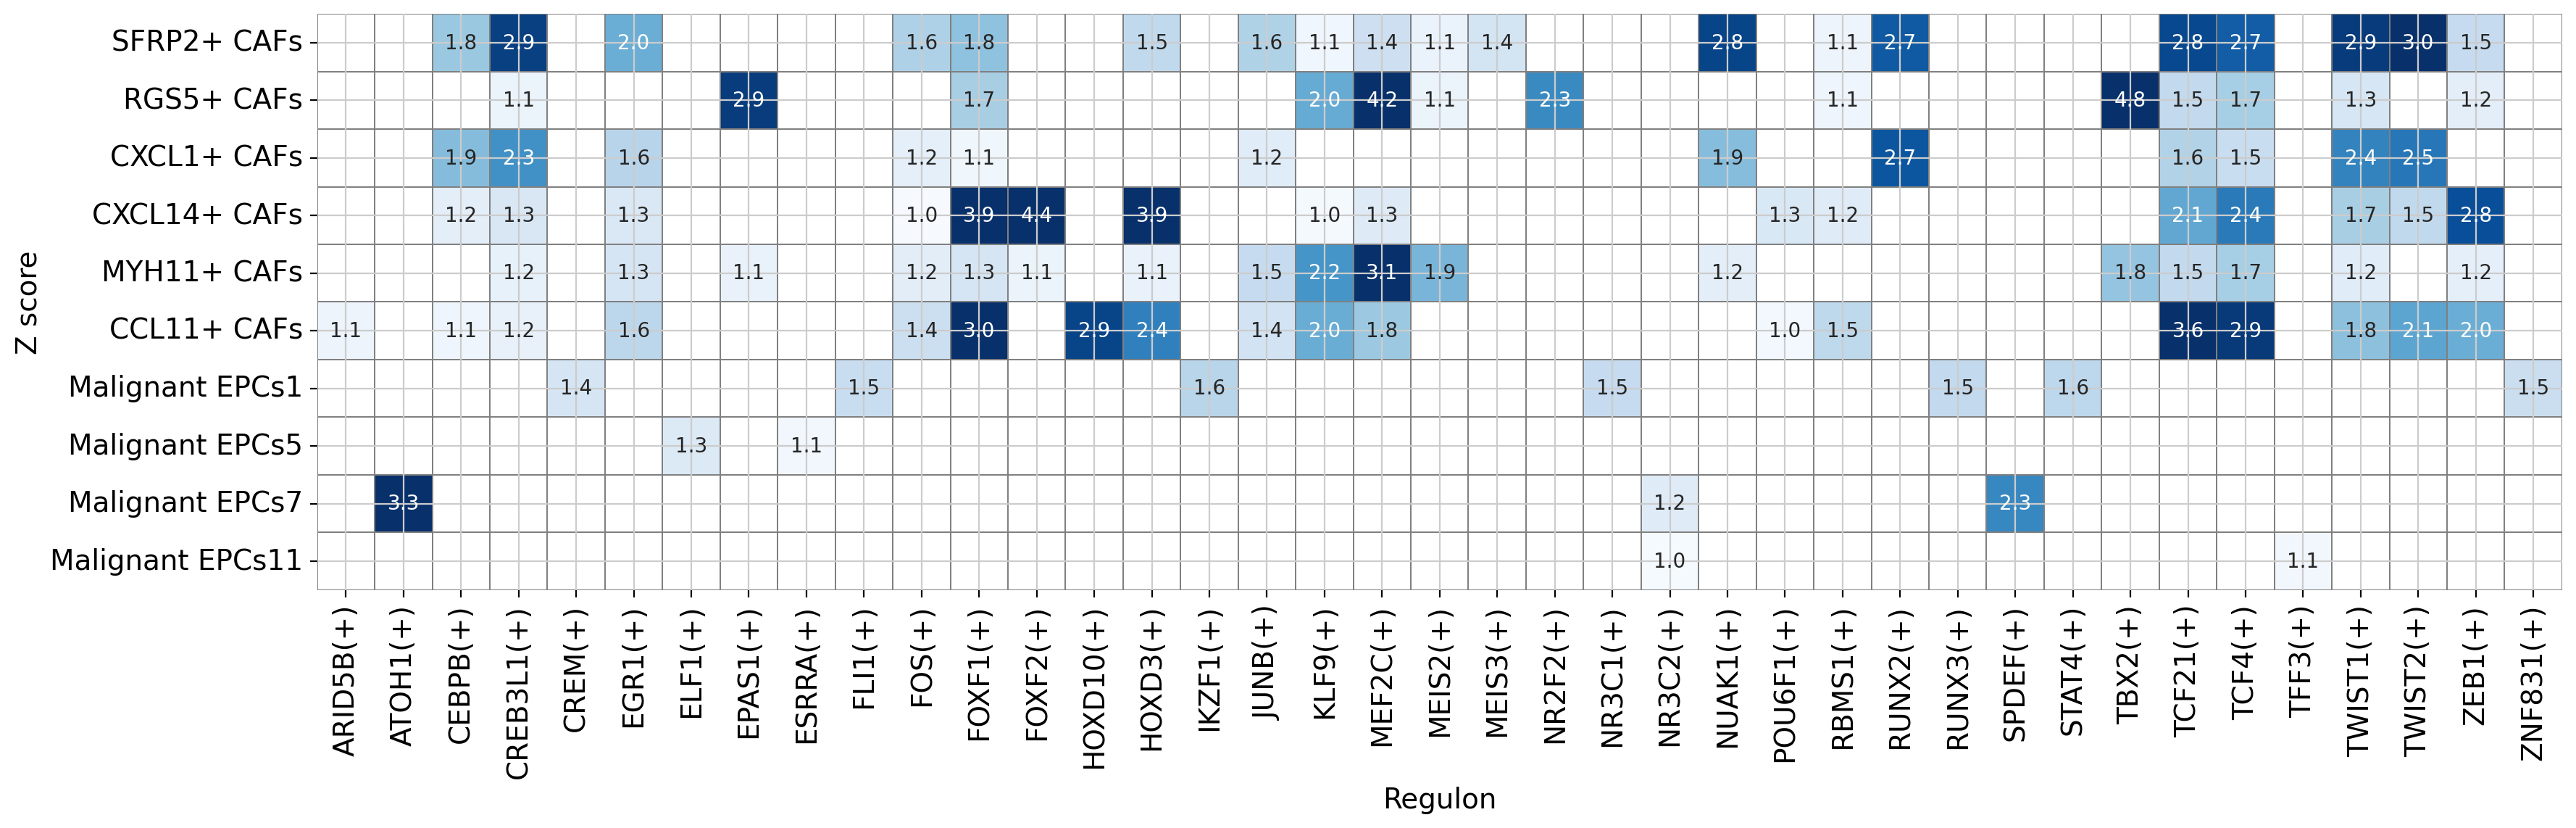

In [19]:
# show Z-score accross all clusters
df_heatmap = pd.pivot_table(data=df_results[df_results.Z >= 1].sort_values('Z', ascending=False),
                           index='Fib_Epi_Cluster', columns='Regulon', values='Z')
fig, ax = plt.subplots(1, 1, figsize=(18, 6))
sns.heatmap(df_heatmap, ax=ax, annot=True, fmt=".1f", linewidths=.7, cbar=False, square=True, linecolor='gray', 
            vmin=1, vmax=3, cmap="Blues", annot_kws={"size": 10})
ax.set_ylabel('Z score')
savesvg('heatmap_regulons_z_score.svg', fig)

In [20]:
# CELL TYPE SPECIFIC REGULATORS - RSS
rss = regulon_specificity_scores(auc_mtx, adata.obs['Fib_Epi_Cluster'])
rss.T.to_csv('YS_epi_RSS.csv')

In [21]:
cats = sorted(list(set(adata.obs['Fib_Epi_Cluster'])))
cats

['CCL11+ CAFs',
 'CXCL1+ CAFs',
 'CXCL14+ CAFs',
 'MYH11+ CAFs',
 'Malignant EPCs1',
 'Malignant EPCs10',
 'Malignant EPCs11',
 'Malignant EPCs2',
 'Malignant EPCs3',
 'Malignant EPCs4',
 'Malignant EPCs5',
 'Malignant EPCs6',
 'Malignant EPCs7',
 'Malignant EPCs8',
 'Malignant EPCs9',
 'RGS5+ CAFs',
 'SFRP2+ CAFs']

In [33]:
sc.set_figure_params(dpi=600, dpi_save=600)

In [34]:
cats = ['Malignant EPCs8','CXCL1+ CAFs','SFRP2+ CAFs']

fig = plt.figure(figsize=(18,5))    # length and width
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss.T[c]
    ax = fig.add_subplot(1,3,num)    # 1 means 1 row, 5 means 5 column
    plot_rss(rss, c, top_n=30, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05)
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001)
 
fig.text(0.5, 0.0, 'Cluster-specific regulaters', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large',
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
savesvg('plots_regulons_rss_Mal8_fib.svg', fig)
plt.show()